In [ ]:
!mkdir -p ~/.kaggle
!cp /content/kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

!kaggle datasets download danialsharifrazi/cad-cardiac-mri-dataset --unzip -p /content/cad_cardiac_mri



cp: cannot stat '/content/kaggle.json': No such file or directory
chmod: cannot access '/root/.kaggle/kaggle.json': No such file or directory
Dataset URL: https://www.kaggle.com/datasets/danialsharifrazi/cad-cardiac-mri-dataset
License(s): unknown
100% 2.86G/2.86G [02:17<00:00, 23.6MB/s]
100% 2.86G/2.86G [02:17<00:00, 22.4MB/s]


In [ ]:
import os
import cv2
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, Model, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns



In [ ]:
def load_images(folder, image_size=(128, 128), extension='.jpg', channels=3):
    images = []
    for root, _, filenames in os.walk(folder):
        for filename in filenames:
            if filename.endswith(extension):
                filepath = os.path.join(root, filename)
                img_data = cv2.imread(filepath, cv2.IMREAD_GRAYSCALE if channels == 1 else cv2.IMREAD_COLOR)
                if img_data is None:
                    print(f"Warning: Image {filename} could not be loaded.")
                    continue
                img_data = cv2.resize(img_data, image_size)
                if channels == 3 and len(img_data.shape) == 2:
                    img_data = cv2.cvtColor(img_data, cv2.COLOR_GRAY2RGB)
                images.append(img_data)
    return np.array(images)



In [ ]:
data_dir = '/content/cad_cardiac_mri'



In [ ]:
# ImageDataGenerator with adjusted augmentations
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.2
)

# Data generators
train_generator = train_datagen.flow_from_directory(
    directory=data_dir,
    target_size=(128, 128),
    batch_size=64,
    class_mode='binary',
    color_mode='rgb',
    subset='training'
)

val_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

val_generator = val_datagen.flow_from_directory(
    directory=data_dir,
    target_size=(128, 128),
    batch_size=64,
    class_mode='binary',
    color_mode='rgb',
    subset='validation'
)

print(f"Training images: {train_generator.samples}")
print(f"Validation images: {val_generator.samples}")



Found 50741 images belonging to 2 classes.
Found 12684 images belonging to 2 classes.
Training images: 50741
Validation images: 12684


In [ ]:
#  MobileNetV2-based model
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dropout, Dense, GlobalAveragePooling2D

def build_simple_model(input_shape=(128, 128, 3)):
    base_model = MobileNetV2(include_top=False, weights='imagenet', input_shape=input_shape)
    base_model.trainable = False  # Freezing base model layers

    inputs = Input(shape=input_shape)
    x = base_model(inputs, training=False)
    x = GlobalAveragePooling2D()(x)
    x = Dropout(0.4)(x)
    outputs = Dense(1, activation='sigmoid')(x)

    return Model(inputs, outputs)



In [ ]:
model = build_simple_model()
model.compile(optimizer=Adam(learning_rate=1e-4), loss='binary_crossentropy', metrics=['accuracy'])

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [ ]:
# callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)
model_checkpoint = ModelCheckpoint('best_model.keras', save_best_only=True, monitor='val_loss')


In [ ]:
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=10,
    callbacks=[early_stopping, reduce_lr, model_checkpoint]
)



Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


793/793 ━━━━━━━━━━━━━━━━━━━━ 331s 401ms/step - accuracy: 0.5458 - loss: 0.8330 - val_accuracy: 0.7170 - val_loss: 0.5576 - learning_rate: 1.0000e-04
Epoch 2/10
793/793 ━━━━━━━━━━━━━━━━━━━━ 362s 384ms/step - accuracy: 0.6614 - loss: 0.6360 - val_accuracy: 0.7522 - val_loss: 0.5144 - learning_rate: 1.0000e-04
Epoch 3/10
793/793 ━━━━━━━━━━━━━━━━━━━━ 319s 379ms/step - accuracy: 0.7028 - loss: 0.5743 - val_accuracy: 0.7629 - val_loss: 0.4974 - learning_rate: 1.0000e-04
Epoch 4/10
793/793 ━━━━━━━━━━━━━━━━━━━━ 320s 378ms/step - accuracy: 0.7265 - loss: 0.5408 - val_accuracy: 0.7686 - val_loss: 0.4834 - learning_rate: 1.0000e-04
Epoch 5/10
793/793 ━━━━━━━━━━━━━━━━━━━━ 302s 379ms/step - accuracy: 0.7367 - loss: 0.5238 - val_accuracy: 0.7759 - val_loss: 0.4772 - learning_rate: 1.0000e-04
Epoch 6/10
793/793 ━━━━━━━━━━━━━━━━━━━━ 301s 377ms/step - accuracy: 0.7493 - loss: 0.5058 - val_accuracy: 0.7760 - val_loss: 0.4758 - learning_rate: 1.0000e-04
Epoch 7/10
793/793 ━━━━━━━━━━━━━━━━━━━━ 319s 373ms/

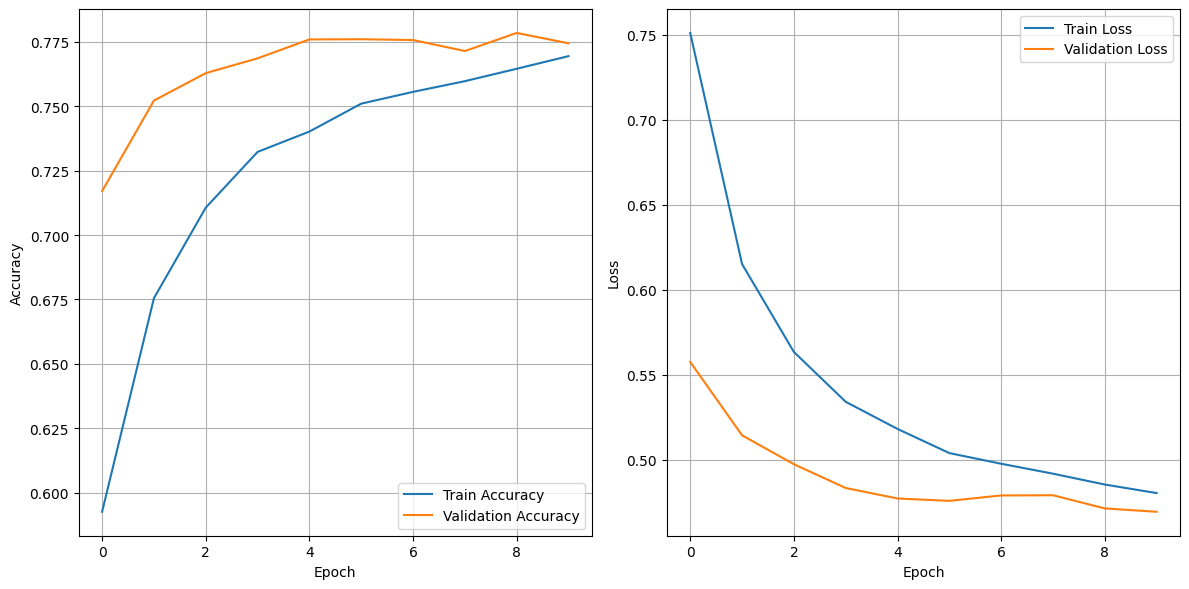

In [ ]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()



In [ ]:
val_images, val_labels = next(val_generator)
predictions = model.predict(val_images)



2/2 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step


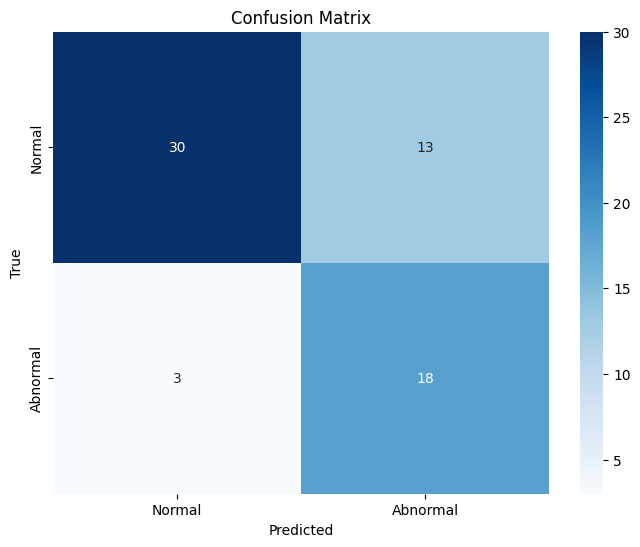

              precision    recall  f1-score   support

      Normal       0.91      0.70      0.79        43
    Abnormal       0.58      0.86      0.69        21

    accuracy                           0.75        64
   macro avg       0.74      0.78      0.74        64
weighted avg       0.80      0.75      0.76        64



In [ ]:
y_true = val_labels.astype(int)
y_pred = (predictions > 0.5).astype(int)

conf_matrix = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Normal', 'Abnormal'], yticklabels=['Normal', 'Abnormal'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

print(classification_report(y_true, y_pred, target_names=['Normal', 'Abnormal']))



2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


<ipython-input-13-0e2bdd7713ef>:20: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  plt.text(0.5, 0.5, str(int(predictions[i] > 0.5)), fontsize=24, ha='center')


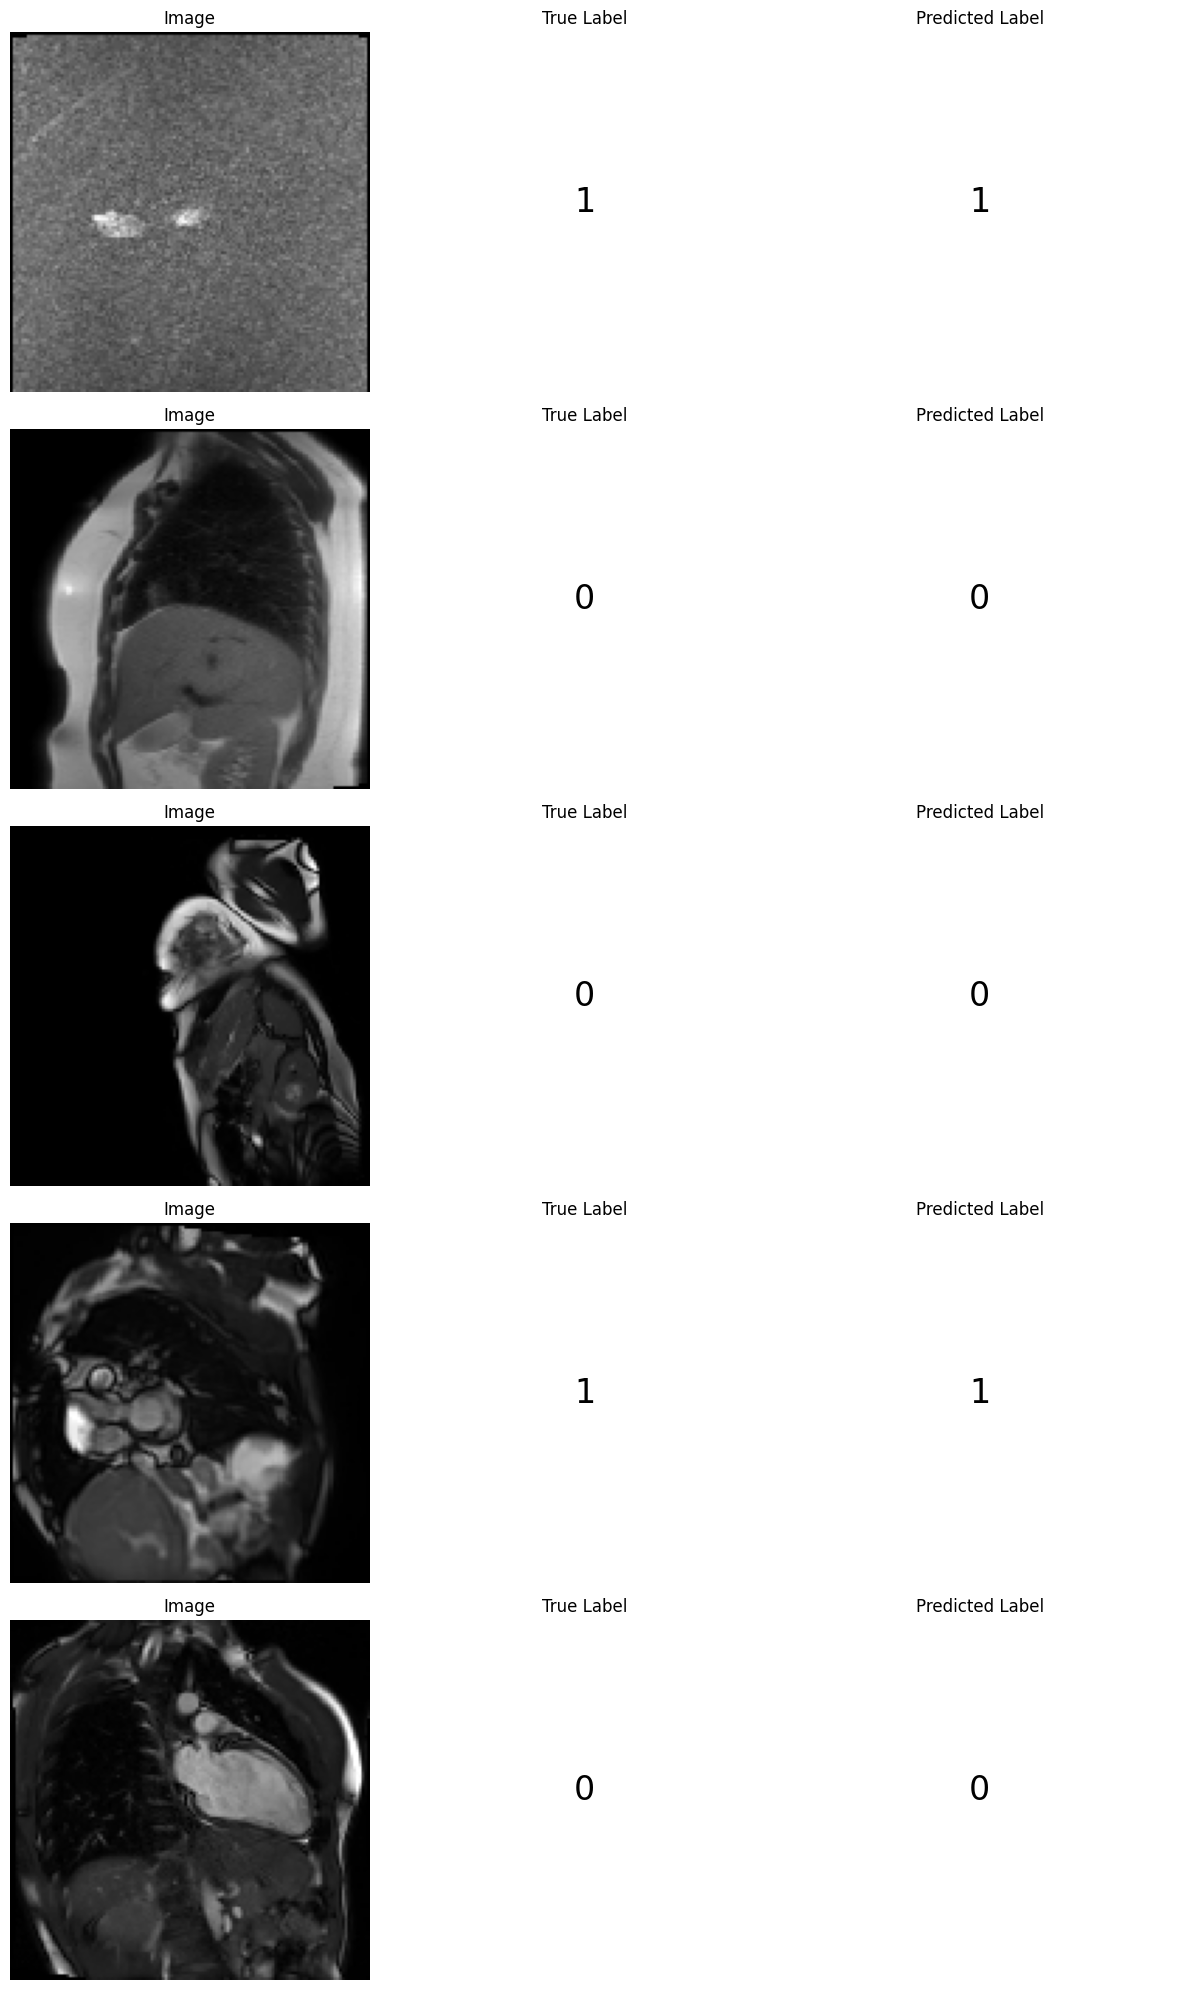

In [ ]:
def display_sample_predictions(model, val_generator, n=5):
    val_images, val_labels = next(val_generator)
    predictions = model.predict(val_images)

    plt.figure(figsize=(12, n * 4))
    for i in range(n):
        plt.subplot(n, 3, 3 * i + 1)
        plt.imshow(val_images[i])
        plt.title("Image")
        plt.axis('off')

        plt.subplot(n, 3, 3 * i + 2)
        plt.title("True Label")
        plt.text(0.5, 0.5, str(int(val_labels[i])), fontsize=24, ha='center')
        plt.axis('off')

        plt.subplot(n, 3, 3 * i + 3)
        plt.title("Predicted Label")
        plt.text(0.5, 0.5, str(int(predictions[i] > 0.5)), fontsize=24, ha='center')
        plt.axis('off')
    plt.tight_layout()
    plt.show()

display_sample_predictions(model, val_generator)
